# 2. Processig IoT Data

## 2.1 Basic EDA and Cleaning: Temporal Plots and Histograms

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

In [37]:
DATA_PATH = "../data/"
filename = "environ_MS83200MS_nowind_3m-10min.json"

In [38]:
df = pd.read_json(DATA_PATH+filename)

In [39]:
df.head()

,timestamp,precipitation,humidity,radiation,sunshine,pressure,temperature
0,2018-09-01 00:00:00,0.0,95.6,0.0,599.2,1016.3,16.1
1,2018-09-01 00:05:00,0.1,NaN,NaN,NaN,NaN,NaN
2,2018-09-01 00:10:00,0.0,95.5,0.0,600.0,1016.4,16.1
3,2018-09-01 00:15:00,0.0,NaN,NaN,NaN,NaN,NaN
4,2018-09-01 00:20:00,0.0,95.2,0.0,598.9,1016.5,16.1


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26175 entries, 0 to 26174
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   timestamp      26175 non-null  datetime64[ns]
 1   precipitation  26162 non-null  float64       
 2   humidity       13085 non-null  float64       
 3   radiation      13085 non-null  float64       
 4   sunshine       13083 non-null  float64       
 5   pressure       13085 non-null  float64       
 6   temperature    13059 non-null  float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 1.4 MB


In [41]:
# Measure missing values: 50% of some column rows are NA
df.isna().sum()/df.shape[0]

timestamp        0.000000
precipitation    0.000497
humidity         0.500096
radiation        0.500096
sunshine         0.500172
pressure         0.500096
temperature      0.501089
dtype: float64

Text(0.5, 0, 'Time')

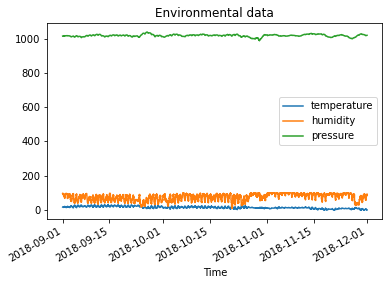

In [42]:
cols = ["temperature", "humidity", "pressure", "timestamp"]

# Create a line/temporal plot
# If we drop the NAs, but the temporal distances are not the same
# We can instead fill the NAs: ffill = hold last sample forward, bfill = back fill
#df[cols].dropna().plot(title="Environmental data", x="timestamp")
df[cols].fillna(method='ffill').plot(title="Environmental data", x="timestamp")

# Label X-Axis
plt.xlabel("Time")

Text(0.5, 0, 'Time')

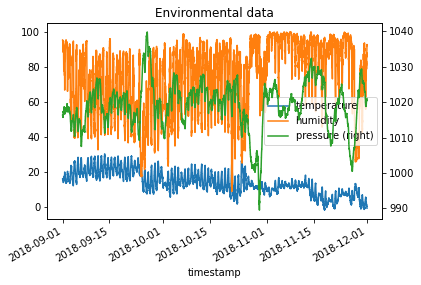

In [43]:
# Plot with 2 axes: curves are set together
df[cols].fillna(method='ffill').plot(title="Environmental data", secondary_y="pressure", x="timestamp")

# Label X-Axis
plt.xlabel("Time")

Text(0, 0.5, 'Frequency')

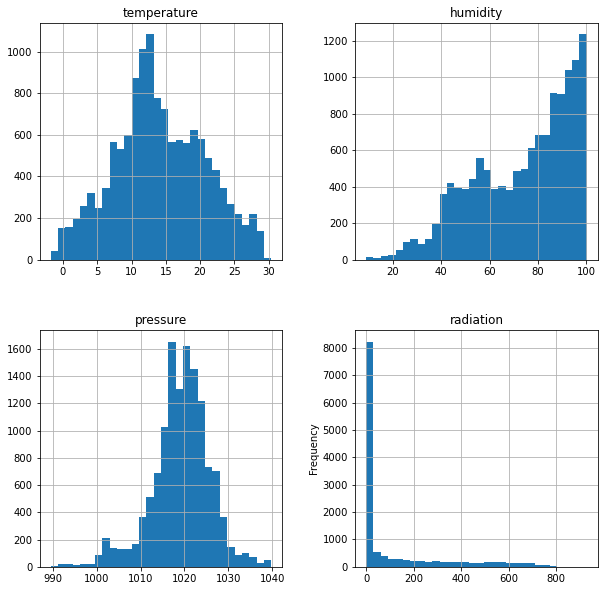

In [44]:
# Create a histogram
cols = ["temperature", "humidity", "pressure", "radiation"]
df[cols].hist(bins=30, figsize=(10,10))
plt.ylabel("Frequency")

## 2.2 Missing Data

We can deal with missing data as follows:

- `dropna()`: drop, if few rows.
- `fillna(method='ffill')`: forward/backward fill, if few rows.

In any case, we need to measure the amount of NAs: `df.isna().sum()`.

Additionally, we need to check whether there is a longer connected period in which we don't have data; we can do that with `resample()`.

In [45]:
# To use resample, the index needs to be a datetime column
df.set_index("timestamp", inplace=True)

In [47]:
# Calculate and print the sum of NA values
print(df.isna().sum())

# Resample data
df_res = df.resample("10min").last()

# Calculate and print NA count
# Temperature seems to have a larger amount of NAs, but it's OK
print(df_res.isna().sum())

precipitation       13
humidity         13090
radiation        13090
sunshine         13092
pressure         13090
temperature      13116
dtype: int64
precipitation    14
humidity         14
radiation        14
sunshine         16
pressure         14
temperature      40
dtype: int64


<AxesSubplot:title={'center':'Environment'}, xlabel='timestamp'>

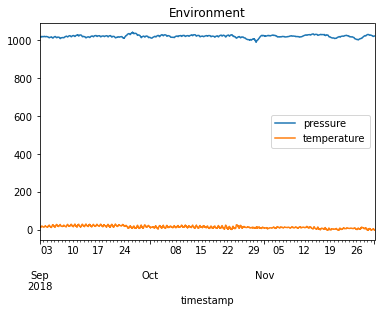

In [52]:
# Plot to visualize if there is any gap
df_res[['pressure', 'temperature']].plot(title="Environment")

## 2.3 Gather Minimalistic Incremental Data

Since we are working with data streams, it is not possible to keep all the data in memory. Because of that, we do **caching**: we store the incoming messages in a cache and save it to disk when a size is reached.

Additionally, it is fundamental to save the timestamp of each message; the timestamp should be as close as possible to the measurement instant. If the message/mesaurement has no timestamp, we can use the publish timestamp, prvided by `mqtt`.

Sometimes the timestamps are ini Unix time. Pandas can reparse them with `to_datetime`.

```python
import datetime
import pandas as pd
import paho.mqtt.subscribe as subscribe

cache = []
MAX_CACHE = 256
def on_message(client, userdata, message):
    data = json.loads(message.payload)
    # If data has no timestamp, save the publish time from mqtt
    publish_time = message.timestamp
    consume_time = datetime.utcnow()
    data['timestamp'] = publish_time
    data['consume_time'] = publish_time    
    cache.append(data)
    if len(cache) > MAX_CACHE:
        # Open file in append mode!
        with open('data.txt', 'a') as f:
            f.writelines(cache)
           # Reset cache
        cache.clear()
        
# Connect function to mqtt datastream
subscribe.callback(on_message,
                   topics="datacamp/energy",
                   hostname=MQTT_HOST)

# Translate timestamp from Unix/other format to datetime
df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
```